In [1]:
# Dependencies
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Load data
data = pd.read_csv('transformed_data.csv', index_col=0, parse_dates=True)
# Set frequency as monthly
data = data.asfreq('MS').dropna()

In [ ]:
# Correlation matrix
corr = data.corr()
cpi_corr = corr['CPIAUCSL'].sort_values(ascending=False)

# Open file to write results
f = open('feature_selection.csv', 'a')

# Select varying number of features
for num_features in range(2, 15):
    # Select features based on correlation
    corr_data = data[cpi_corr.index[0: num_features]]

    # Split into train/test
    periods = 6 # test using the last 6 months
    train_data = corr_data[:-periods].copy()
    test_data = corr_data[-periods:].copy()

    # Train the VAR model
    var_model = VAR(train_data)
    selected_lags = var_model.select_order()
    best_lag = selected_lags.aic  # Choose based on AIC or BIC
    # iterate over lags
    try:
        for lag in range(1, best_lag + 4):
            var_results = var_model.fit(lag)

            # Forecast 
            forecast = var_results.forecast(train_data.values, steps=periods)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(test_data['CPIAUCSL'], forecast[:, 0]))
            print(f"Number of features: {num_features}, RMSE: {rmse}, Lags: {lag}")
            f.write(f"{num_features},{lag},{rmse},{rmse / test_data['CPIAUCSL'].mean() * 100:.2f}\n")
    except Exception as e:
        print(f"Error with {lag} lags: {e}")

# Close the file
f.close()


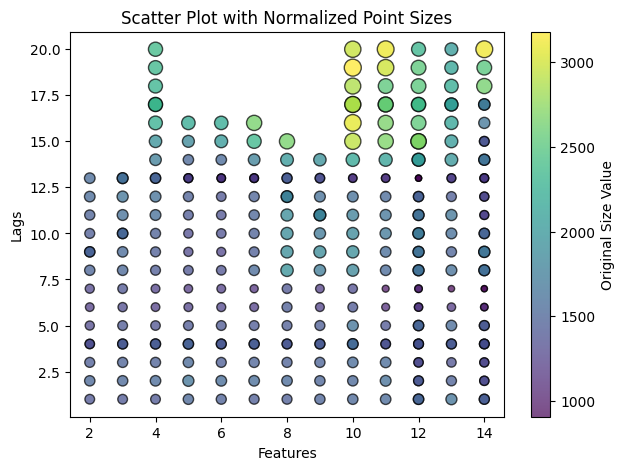

In [3]:
# Normalize sizes to a reasonable range for visualization

# Load the results
results = pd.read_csv('feature_selection.csv')

scaler = MinMaxScaler(feature_range=(20, 150))  # Adjust range as needed
sizes_normalized = scaler.fit_transform(results["Relative_RMSE"].values.reshape(-1, 1)).flatten()

# Create scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(results["Features"], results["Lags"], s=sizes_normalized, c=results["Relative_RMSE"], cmap='viridis', alpha=0.7, edgecolors="k")

# Labels & Title
plt.xlabel("Features")
plt.ylabel("Lags")
plt.title("Scatter Plot with Normalized Point Sizes")
plt.colorbar(label="Original Size Value")
plt.show()

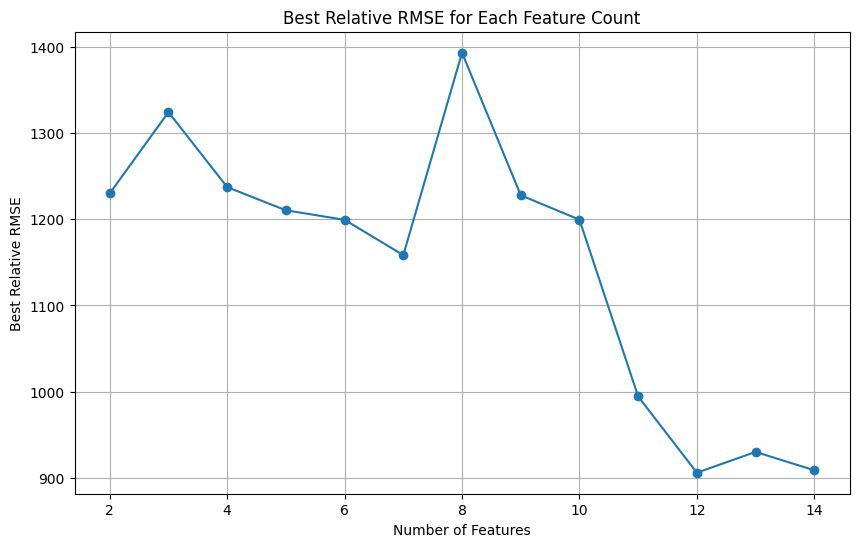

In [4]:
# Select the best Relative_RMSE at each feature count
best_rmse = results.groupby("Features")["Relative_RMSE"].min().reset_index()
# Plot the best RMSE for each feature count
plt.figure(figsize=(10, 6))
plt.plot(best_rmse["Features"], best_rmse["Relative_RMSE"], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Best Relative RMSE")
plt.title("Best Relative RMSE for Each Feature Count")
plt.grid()
plt.show()

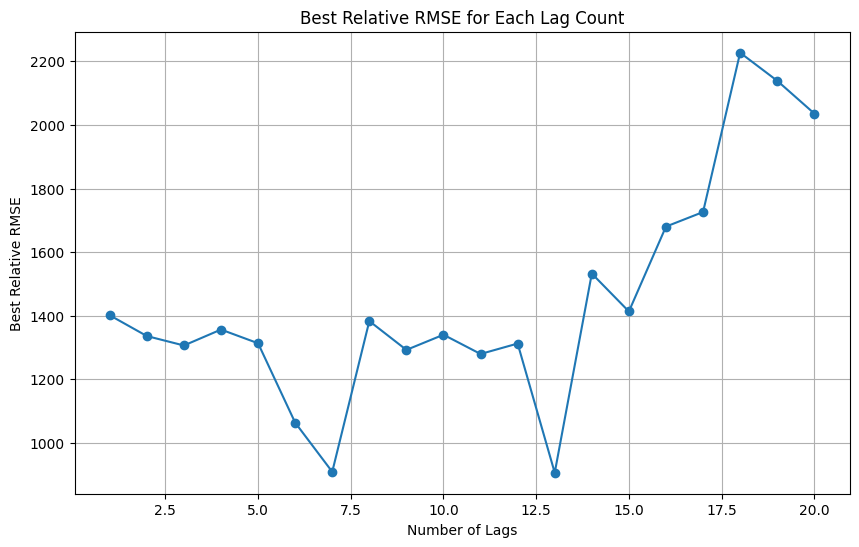

In [5]:
# Best Relative_RMSE at each lag
best_lag_rmse = results.groupby("Lags")["Relative_RMSE"].min().reset_index()
# Plot the best RMSE for each lag
plt.figure(figsize=(10, 6))
plt.plot(best_lag_rmse["Lags"], best_lag_rmse["Relative_RMSE"], marker='o')
plt.xlabel("Number of Lags")
plt.ylabel("Best Relative RMSE")
plt.title("Best Relative RMSE for Each Lag Count")
plt.grid()
plt.show()